In [0]:
%run "./0.Configurations"

In [0]:
import matplotlib.pyplot as plt
import seaborn as sns

In [0]:
economical_bowlers_powerplay = spark.sql("""
SELECT 
p.player_name, 
AVG(b.runs_scored) AS avg_runs_per_ball, 
COUNT(b.bowler_wicket) AS total_wickets
FROM global_temp.ball_by_ball b
JOIN global_temp.player_match pm ON b.match_id = pm.match_id AND b.bowler = pm.player_id
JOIN global_temp.player p ON pm.player_id = p.player_id
WHERE b.over_id <= 6
GROUP BY p.player_name
HAVING COUNT(*) >= 1
ORDER BY avg_runs_per_ball, total_wickets DESC
""")

In [0]:
economical_bowlers_powerplay.show(5)

+-----------+-------------------+-------------+
|player_name|  avg_runs_per_ball|total_wickets|
+-----------+-------------------+-------------+
| sm harwood| 0.3157894736842105|            0|
|    a zampa|0.42857142857142855|            0|
|  gr napier|                0.5|            0|
| ankit soni|                0.5|            0|
|   aj finch|                0.5|            0|
+-----------+-------------------+-------------+
only showing top 5 rows



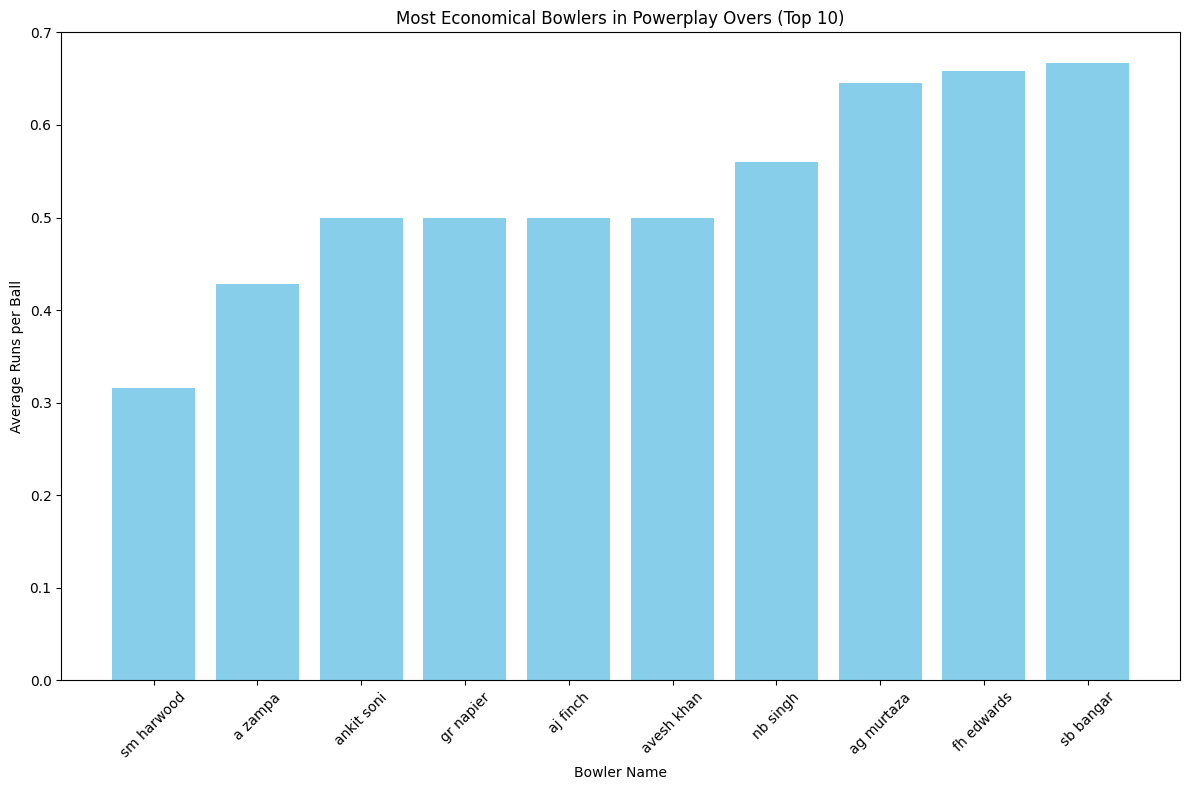

<Figure size 640x480 with 0 Axes>

In [0]:
economical_bowlers_pd = economical_bowlers_powerplay.toPandas()

# Visualizing using Matplotlib
plt.figure(figsize=(12, 8))

# Limiting to top 10 for clarity in the plot
top_economical_bowlers = economical_bowlers_pd.nsmallest(10, 'avg_runs_per_ball')

plt.bar(top_economical_bowlers['player_name'], top_economical_bowlers['avg_runs_per_ball'], color='skyblue')
plt.xlabel('Bowler Name')
plt.ylabel('Average Runs per Ball')
plt.title('Most Economical Bowlers in Powerplay Overs (Top 10)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

plt.savefig('economical_bowler.png')

In [0]:
toss_impact_individual_matches = spark.sql("""
SELECT m.match_id, m.toss_winner, m.toss_name, m.match_winner,
       CASE WHEN m.toss_winner = m.match_winner THEN 'Won' ELSE 'Lost' END AS match_outcome
FROM global_temp.match m
WHERE m.toss_name IS NOT NULL
ORDER BY m.match_id
""")

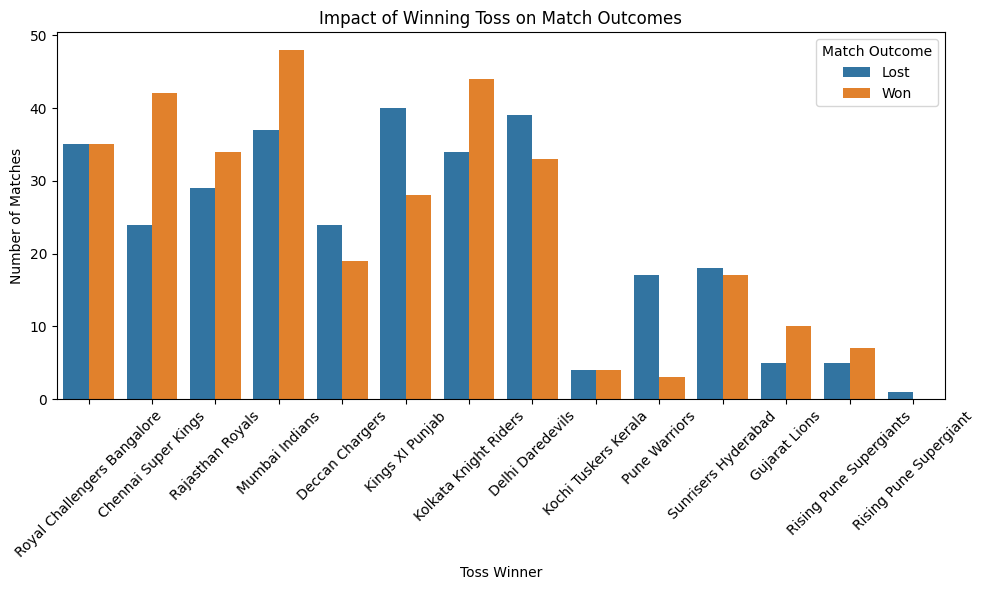

<Figure size 640x480 with 0 Axes>

In [0]:
toss_impact_pd = toss_impact_individual_matches.toPandas()

# Creating a countplot to show win/loss after winning toss
plt.figure(figsize=(10, 6))
sns.countplot(x='toss_winner', hue='match_outcome', data=toss_impact_pd)
plt.title('Impact of Winning Toss on Match Outcomes')
plt.xlabel('Toss Winner')
plt.ylabel('Number of Matches')
plt.legend(title='Match Outcome')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

plt.savefig('toss_impact.png')

In [0]:
average_runs_in_wins = spark.sql("""
SELECT p.player_name, AVG(b.runs_scored) AS avg_runs_in_wins, COUNT(*) AS innings_played
FROM global_temp.ball_by_ball b
JOIN global_temp.player_match pm ON b.match_id = pm.match_id AND b.striker = pm.player_id
JOIN global_temp.player p ON pm.player_id = p.player_id
JOIN global_temp.match m ON pm.match_id = m.match_id
WHERE m.match_winner = pm.player_team
GROUP BY p.player_name
ORDER BY avg_runs_in_wins ASC
""")
average_runs_in_wins.show()

+---------------+-------------------+--------------+
|    player_name|   avg_runs_in_wins|innings_played|
+---------------+-------------------+--------------+
|smsm senanayake|                0.0|             1|
|     kp appanna|                0.0|             1|
|      jj bumrah|                0.0|             3|
|       i sharma|                0.0|             1|
|       j theron|                0.0|             2|
|       ts mills|                0.0|             3|
|       vr aaron|                0.0|             5|
|        a nehra|                0.0|             2|
|      sn thakur|                0.0|             2|
|  anirudh singh|                0.0|             1|
|     t thushara|                0.2|             5|
|      sa abbott|               0.25|             4|
|  yashpal singh|                0.3|            20|
|    s sreesanth| 0.3333333333333333|             3|
|    kc cariappa| 0.3333333333333333|             3|
|     jd unadkat|                0.4|         

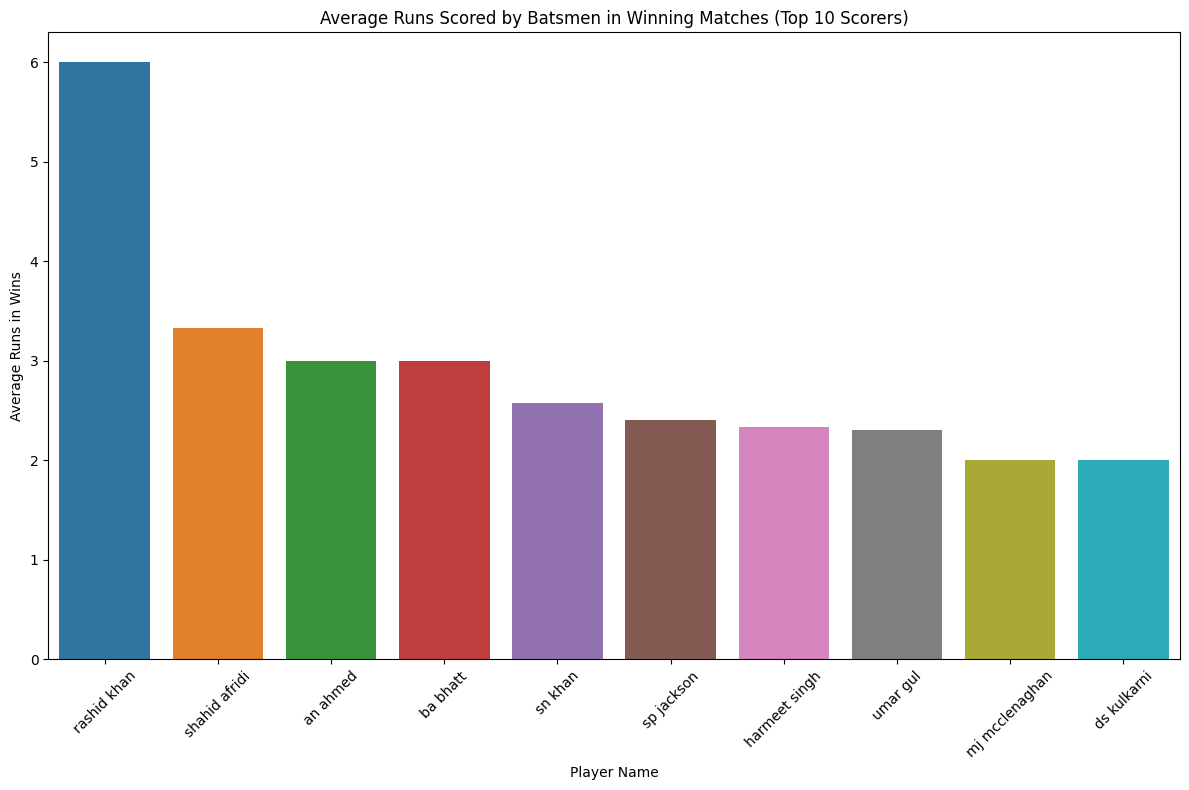

<Figure size 640x480 with 0 Axes>

In [0]:
average_runs_pd = average_runs_in_wins.toPandas()

# Using seaborn to plot average runs in winning matches
plt.figure(figsize=(12, 8))
top_scorers = average_runs_pd.nlargest(10, 'avg_runs_in_wins')
sns.barplot(x='player_name', y='avg_runs_in_wins', data=top_scorers)
plt.title('Average Runs Scored by Batsmen in Winning Matches (Top 10 Scorers)')
plt.xlabel('Player Name')
plt.ylabel('Average Runs in Wins')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

plt.savefig('avg_runs.png')

In [0]:
scores_by_venue = spark.sql("""
SELECT venue_name, AVG(total_runs) AS average_score, MAX(total_runs) AS highest_score
FROM (
    SELECT ball_by_ball.match_id, match.venue_name, SUM(runs_scored) AS total_runs
    FROM global_temp.ball_by_ball
    JOIN global_temp.match ON ball_by_ball.match_id = match.match_id
    GROUP BY ball_by_ball.match_id, match.venue_name
)
GROUP BY venue_name
ORDER BY average_score DESC
""")

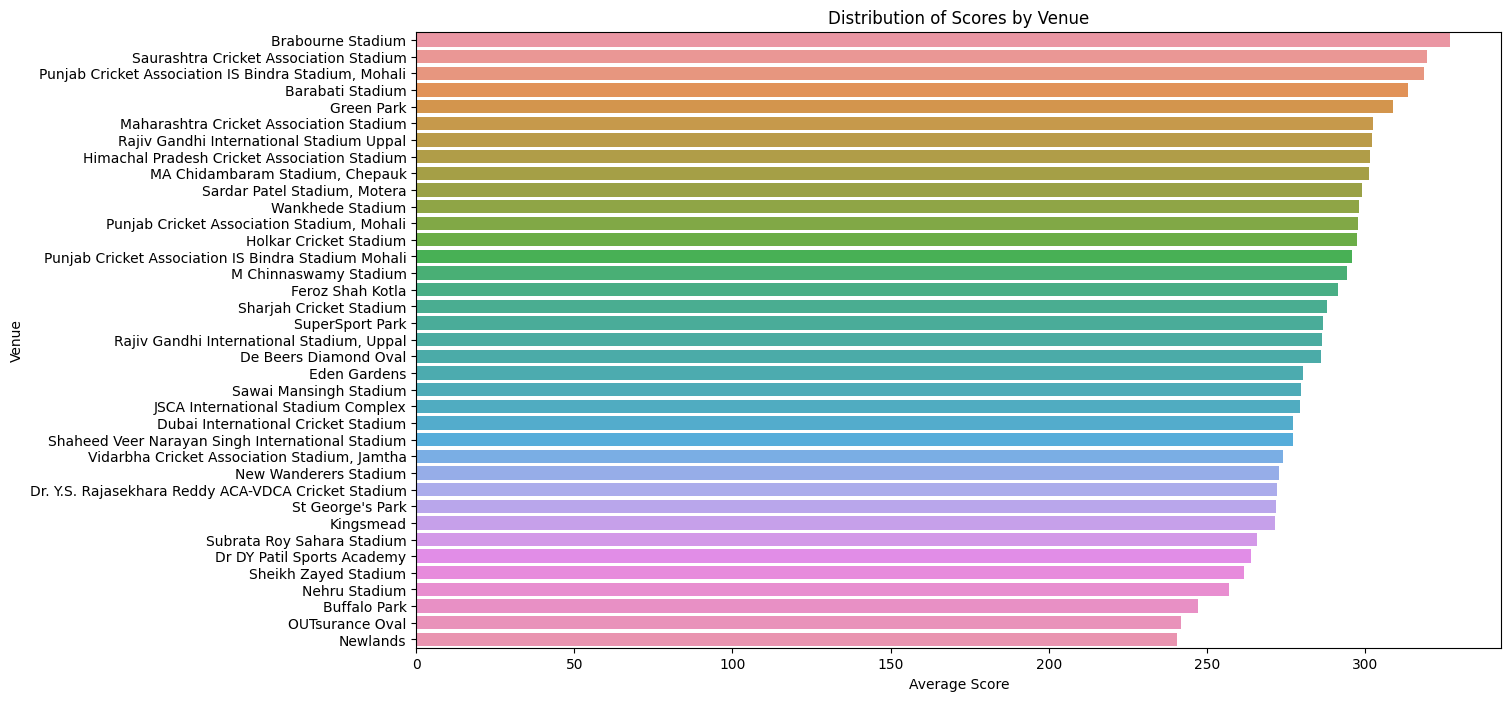

<Figure size 640x480 with 0 Axes>

In [0]:
# Convert to Pandas DataFrame
scores_by_venue_pd = scores_by_venue.toPandas()

# Plot
plt.figure(figsize=(14, 8))
sns.barplot(x='average_score', y='venue_name', data=scores_by_venue_pd)
plt.title('Distribution of Scores by Venue')
plt.xlabel('Average Score')
plt.ylabel('Venue')
plt.show()

plt.savefig('scores_by_venue.png')

In [0]:
team_toss_win_performance = spark.sql("""
SELECT team1, COUNT(*) AS matches_played, SUM(CASE WHEN toss_winner = match_winner THEN 1 ELSE 0 END) AS wins_after_toss
FROM global_temp.match
WHERE toss_winner = team1
GROUP BY team1
ORDER BY wins_after_toss DESC
""")

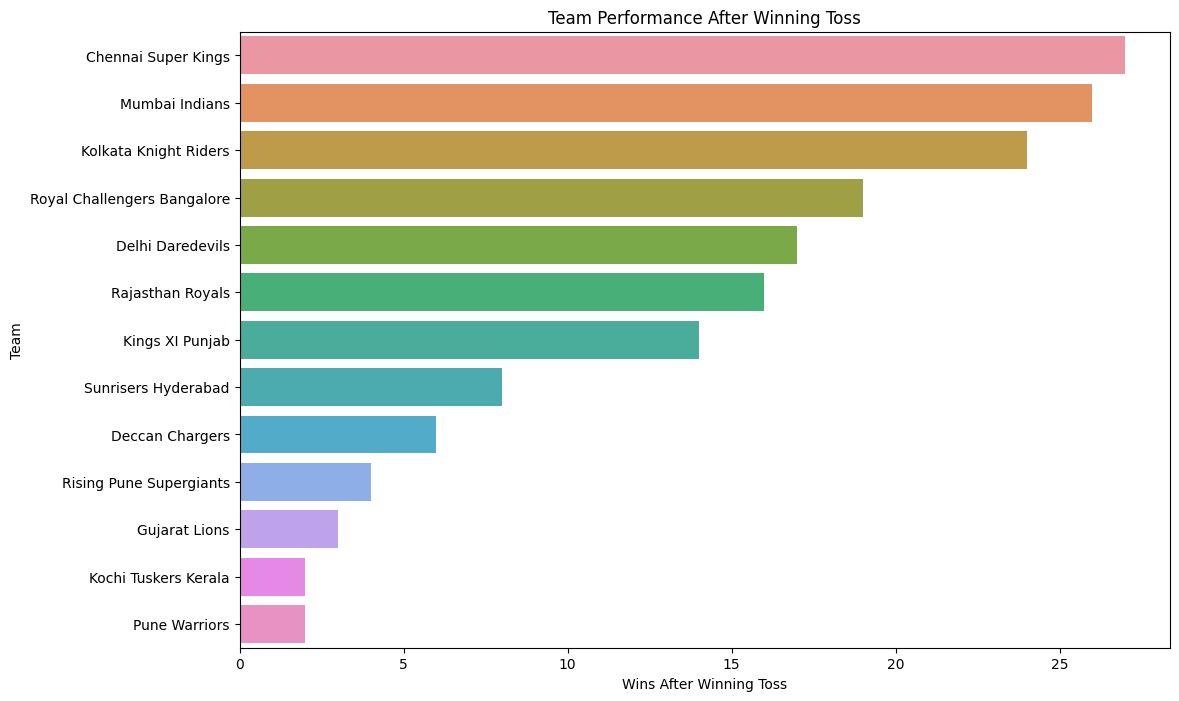

<Figure size 640x480 with 0 Axes>

In [0]:
team_toss_win_performance_pd =team_toss_win_performance.toPandas()

plt.figure(figsize=(12, 8))
sns.barplot(x='wins_after_toss', y='team1', data=team_toss_win_performance_pd)
plt.title('Team Performance After Winning Toss')
plt.xlabel('Wins After Winning Toss')
plt.ylabel('Team')
plt.show()

plt.savefig('team_toss_win.png')